# Continuous stirred tank reactor (CSTR) - Linear Quadratic Regulator (LQR)

In this Jupyter Notebook we illustrate the example CSTR

**Open an interactive online Jupyter Notebook with this content on Binder:**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/do-mpc/do-mpc.git/master?filepath=%2Fdocumentation%2Fsource%2Fexample_gallery%2FCSTR.ipynb)

The example consists of the three modules **template_model.py**, which describes the system model, **template_lqr.py**, which defines the settings for the control and **template_simulator.py**, which sets the parameters for the simulator.
The modules are used in **main.py** for the closed-loop execution of the controller.
The file **post_processing.py** is used for the visualization of the closed-loop control run.

In the following the different parts are presented. But first, we start by importing basic modules and **do-mpc**.

In [1]:
import numpy as np
import sys
from casadi import *
from casadi.tools import *
import matplotlib.pyplot as plt
import pdb

# Add do_mpc to path. This is not necessary if it was installed via pip
import os
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc
from do_mpc.tools import Timer
import pickle
import time

## Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`.
The considered model of the CSTR is continuous and has 4 states and 2 control inputs.
The model is initiated by:

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

### States and control inputs

The four states are concentration of reactant A ($C_{\text{A}}$), the concentration of reactant B ($C_{\text{B}}$), the temperature inside the reactor ($T_{\text{R}}$) and the temperature of the cooling jacket ($T_{\text{J}}$):

In [3]:
# States struct (optimization variables):
C_a = model.set_variable(var_type='_x', var_name='C_a', shape=(1,1))
C_b = model.set_variable(var_type='_x', var_name='C_b', shape=(1,1))
T_R = model.set_variable(var_type='_x', var_name='T_R', shape=(1,1))
T_J = model.set_variable(var_type='_x', var_name='T_J', shape=(1,1))

The control inputs are the feed $Fr$ and the heat removal by the jacket $Q_J$:

In [4]:
# Input struct (optimization variables):
Fr = model.set_variable(var_type='_u', var_name='Fr')
Q_J = model.set_variable(var_type='_u', var_name='Q_J')

### ODE and parameters

The system model is described by the ordinary differential equation:

\begin{align}
\dot{C}_{\text{A}} &= \frac{Fr}{V} \cdot (C_{\text{A}_{in}} - C_{\text{A}}) - r_1, \\
\dot{C}_{\text{B}} &= -\frac{Fr}{V} \cdot C_{\text{B}} + r_1 - r_2, \\
\dot{T}_{\text{R}} &= \frac{Fr}{V} \cdot (T_{\text{in}-T_{\text{R}}}) -\frac{k \cdot A \cdot (T_{\text{R}}-T_{\text{J}})}{\rho \cdot c_{\text{p}} \cdot V} +\frac{\Delta H_{\text{R,1}}\cdot (-r_1)+\Delta H_{\text{R,2}}\cdot (-r_2)}{\rho \cdot c_{\text{p}}}, \\
\dot{T}_{\text{J}} &= \frac{-Q_{\text{J}} + k \cdot A \cdot (T_{\text{R}}-T_{\text{J}})}{m_j \cdot C_{p,J}}, \\
\end{align}

where

\begin{align}
r_1 &= k0_1\cdot\exp(\frac{-E_{\text{{R,1}}}}{T_{\text{R}}})\cdot C_{\text{A}} \\
r_2 &= k0_2\cdot\exp(\frac{-E_{\text{{R,2}}}}{T_{\text{R}}})\cdot C_{\text{B}}\\
\end{align}

In [5]:
# Certain parameters
K0_1 = 2.145e10      # [min^-1]
K0_2 = 2.145e10      # [min^-1]
E_R_1 = 9758.3       # [K]
E_R_2 = 9758.3       # [K]
delH_R_1 = -4200     # [kJ/kmol]
del_H_R_2 = -11000   # [kJ/kmol]
T_in = 387.05        # [K]
rho = 934.2          # [kg/m^3]
cp = 3.01            # [kJ/m^3.K]
cp_J = 2             # [kJ/m^3.K]
m_j = 5              # [kg]
kA = 14.448          # [kJ/min.K]
C_ain = 5.1          # [kmol/m^3]
V = 0.01             # [m^3]

In the next step, we formulate the $r_i$-s:

In [6]:
# Auxiliary terms
r_1 = K0_1 * exp((-E_R_1)/((T_R)))*C_a
r_2 = K0_2 * exp((-E_R_2)/((T_R)))*C_b

WIth the help ot the $k_i$-s and other available parameters we can define the ODEs:

In [7]:
# Differential equations
model.set_rhs('C_a', (Fr/V)*(C_ain-C_a)-r_1)
model.set_rhs('C_b', -(Fr/V)*C_b + r_1 - r_2)
model.set_rhs('T_R', (Fr/V)*(T_in-T_R)-(kA/(rho*cp*V))*(T_R-T_J)+(1/(rho*cp))*((delH_R_1*(-r_1))+(del_H_R_2*(-r_2))))
model.set_rhs('T_J', (1/(m_j*cp_J))*(-Q_J+kA*(T_R-T_J)))

Finally, the model setup is completed:

In [8]:
# Build the model
model.setup()

To design a LQR, we need a discrete Linear Time Invariant (LTI) system. In the following blocks of code, we will obtain such a model. Firstly, we will linearize a non-linear model around equilibrium point.

In [9]:
# Steady state values
F_ss = 0.002365    # [m^3/min]
Q_ss = 18.5583     # [kJ/min]
    
C_ass = 1.6329     # [kmol/m^3]
C_bss = 1.1101     # [kmolm^3]
T_Rss = 398.6581   # [K]
T_Jss = 397.3736   # [K]

uss = np.array([[F_ss],[Q_ss]])
xss = np.array([[C_ass],[C_bss],[T_Rss],[T_Jss]])

# Linearize the non-linear model
linearmodel = do_mpc.model.linearize(model, xss, uss)

Now we dicretize the continuous LTI model with sampling time $t_\text{step} = 0.5$ .

In [10]:
t_step = 0.5
model_dc = linearmodel.discretize(t_step, conv_method = 'zoh') # ['zoh','foh','bilinear','euler','backward_diff','impulse']

d:\Study_Materials\student_job\research_assistant\work_files\do_mpc_git\do-mpc\documentation\source\example_gallery\..\..\..\do_mpc\model\_linearmodel.py:280: UserWarning: sampling time is 0.5
  warnings.warn('sampling time is {}'.format(t_step))


## Controller

Now, we design Linear Quadratic Regulator for the above configured model. First, we create an instance of the class.

In [11]:
# Initialize the controller
lqr = do_mpc.controller.LQR(model_dc)

We choose the prediction horizon `n_horizon = 10`, the time step `t_step = 0.5s` second.

In [12]:
# Initialize parameters
setup_lqr = {'t_step':t_step}
lqr.set_param(**setup_lqr)

### Objective

The goal of CSTR is to drive the states to the desired set points.

**Inputs**
\begin{align}
    Fr_{\text{ref}} &= 0.002365 \frac{m^3}{min} \\
    Q_{\text{J,ref}} &= 18.5583 \frac{kJ}{min} \\
\end{align}
**States**
\begin{align}
    C_{\text{A,ref}} &= 1.6329 \frac{kmol}{m^3} \\
    C_{\text{B,ref}} &= 1.1101 \frac{kmol}{m^3} \\
    T_{\text{R,ref}} &= 398.6581 K \\
    T_{\text{J,ref}} &= 397.3736 K \\
\end{align}


In [13]:
# Set objective
Q = 10*np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
R = np.array([[1e-1,0],[0,1e-5]])
    
lqr.set_objective(Q=Q, R=R)

Now we run the LQR with the rated input. In order to do so, we set the cost matrix for the rated input as below:

In [14]:
Rdelu = np.array([[1e8,0],[0,1]])
lqr.set_rterm(delR = Rdelu)

Finally, LQR setup is completed

In [15]:
# set up lqr
lqr.setup()

d:\Study_Materials\student_job\research_assistant\work_files\do_mpc_git\do-mpc\documentation\source\example_gallery\..\..\..\do_mpc\controller\_lqr.py:457: UserWarning: discrete infinite horizon gain will be computed since prediction horizon is set to default value 0
  warnings.warn('discrete infinite horizon gain will be computed since prediction horizon is set to default value 0')


## Estimator

We assume, that all states can be directly measured (state-feedback):

In [16]:
estimator = do_mpc.estimator.StateFeedback(model)

## Simulator

To create a simulator in order to run the LQR in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the non-linear model:

In [17]:
simulator = do_mpc.simulator.Simulator(model)

For the simulation, we use the same time step `t_step` as for the optimizer:

In [18]:
params_simulator = {
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': t_step
}

simulator.set_param(**params_simulator)

To finish the configuration of the simulator, call:

In [19]:
simulator.setup()

## Closed-loop simulation

For the simulation of the LQR configured for the CSTR, we inspect the file **main.py**.
We define the initial state of the system and set it for all parts of the closed-loop configuration. Furthermore, we set the desired destination for the states and input.

In [20]:
# Set the initial state of simulator:
C_a0 = 0
C_b0 = 0
T_R0 = 387.05
T_J0 = 387.05

x0 = np.array([C_a0, C_b0, T_R0, T_J0]).reshape(-1,1)

simulator.x0 = x0

lqr.set_setpoint(xss=xss,uss=uss)

Now, we simulate the closed-loop for 100 steps:

In [30]:
#Run LQR main loop:
sim_time = 100
for k in range(sim_time):
    u0 = lqr.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = y_next

## Plotting

Now we plot the results obtained in the closed loop simulation.

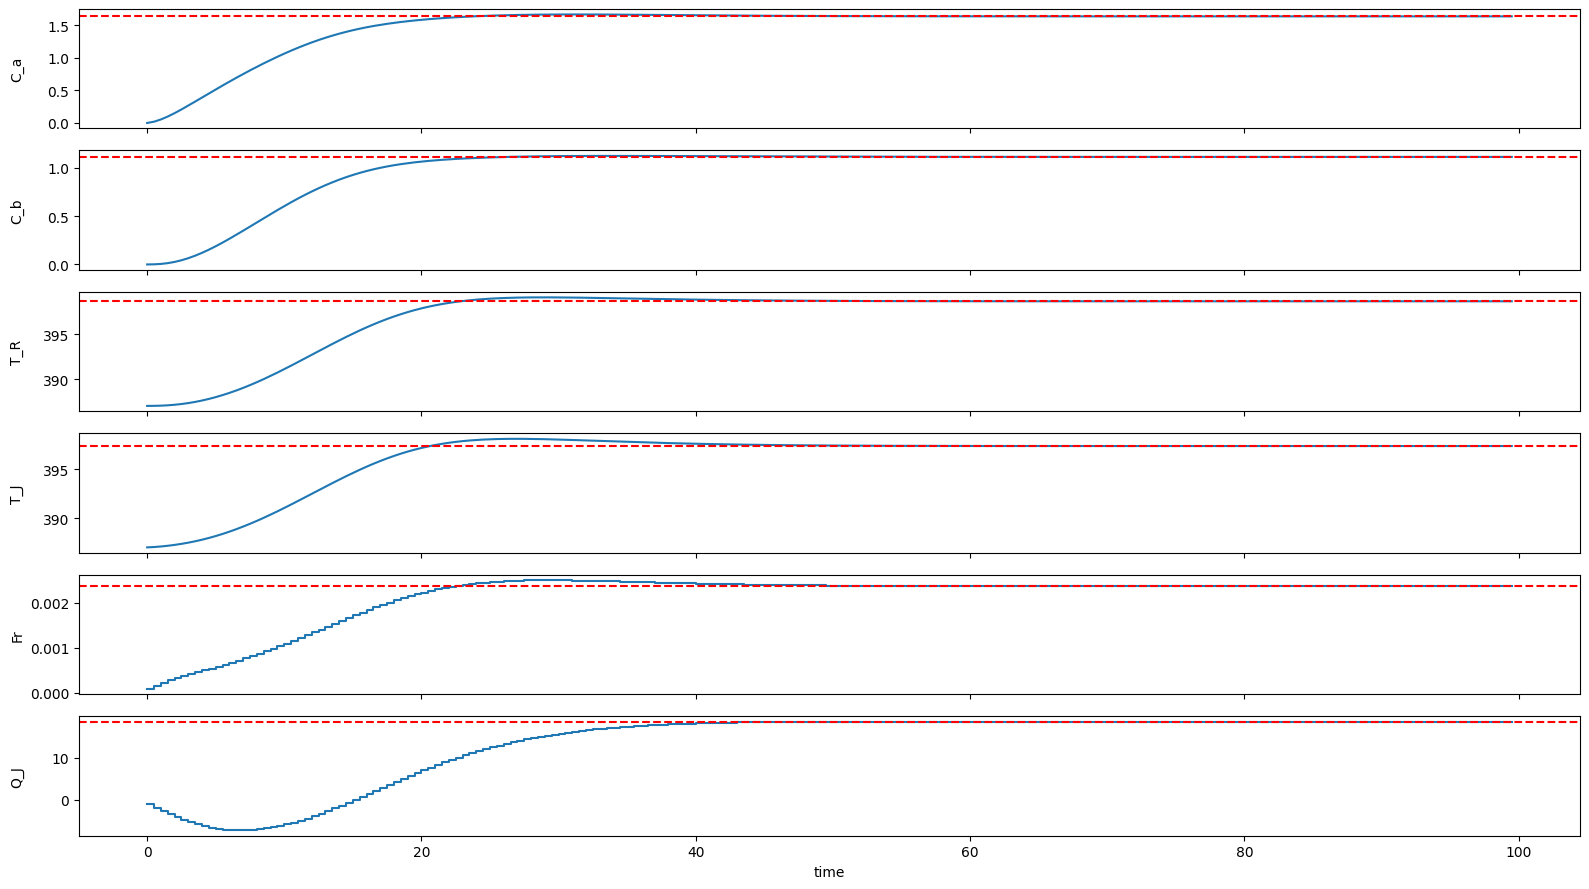

In [31]:
fig, ax, graphics = do_mpc.graphics.default_plot(simulator.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
ax[0].axhline(y=C_ass,xmin=0,xmax=sim_time*t_step,color='r',linestyle='dashed')
ax[1].axhline(y=C_bss,xmin=0,xmax=sim_time*t_step,color='r',linestyle='dashed')
ax[2].axhline(y=T_Rss,xmin=0,xmax=sim_time*t_step,color='r',linestyle='dashed')
ax[3].axhline(y=T_Jss,xmin=0,xmax=sim_time*t_step,color='r',linestyle='dashed')
ax[4].axhline(y=F_ss,xmin=0,xmax=sim_time*t_step,color='r',linestyle='dashed')
ax[5].axhline(y=Q_ss,xmin=0,xmax=sim_time*t_step,color='r',linestyle='dashed')
plt.show()  

In [24]:
ax[0]

<AxesSubplot:ylabel='C_a'>